# iZcyBurningForest
## Config Initialization

In [1]:
%pip install matplotlib
# also do: sudo apt-get install ffmpeg

Note: you may need to restart the kernel to use updated packages.


## Initialize Packages

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML  # for embedded matplotlib animation
from math import *
from random import *
import time

matplotlib.rc('animation', html='html5')
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

## Cleaning .mp4

In [3]:
import os

def delete_mp4_files(directory):
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        # Check if the file ends with '.mp4'
        if filename.endswith(".mp4"):
            # Construct the full path to the file
            file_path = os.path.join(directory, filename)
            # Delete the file
            os.remove(file_path)
            print(f"Deleted: {file_path}")

# Get the current directory
current_directory = os.getcwd()

# Call the function to delete .mp4 files in the current directory
delete_mp4_files(current_directory)


## Defining States

In [4]:
## Define States
global EMPTY, TREE, BURNING, BURNING_MAX
EMPTY = 0
TREE = 1
BURNING = 2
BURNING_MAX = 3

global grid_ani

## Colouring

In [5]:
def makeColorGrid(grid):
    n = grid.shape[0]
    colorGrid = np.zeros((n, n, 3))
    colorGrid[:, :, 0] = 1
    colorGrid[:, :, 1] = 1
    for i in range(0, n):
        for j in range(0, n):
            if (grid[i, j] == TREE):
                colorGrid[i, j, 0] = 0.1
                colorGrid[i, j, 1] = 0.75
                colorGrid[i, j, 2] = 0.02
            if (grid[i, j] >= BURNING and grid[i, j] <= BURNING_MAX):
                colorGrid[i, j, 0] = 0.6
                colorGrid[i, j, 1] = 0.2
                colorGrid[i, j, 2] = 0.1
    return colorGrid

## Drawing

In [6]:
def drawing(grids, save=False):
    # Execute
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(makeColorGrid(grids[0,:,:]), animated=True)

    # The animation function: called to produce a frame for each generation.
    def updatefig(i, *args):
        im.set_array(makeColorGrid(grids[i,:,:]))
        return im,

    grid_ani = animation.FuncAnimation(
        fig, updatefig, save_count = len(grids), interval=500, blit=False)
    plt.show()

    # Get current time in seconds since the epoch
    current_time = int(time.time())

    # To save the animation, use the command, placed before HTML:
    if save:
        grid_ani.save(f'Fire {current_time}.mp4', writer=writer)

## Initialize Forest

In [7]:
def initForest(n):
    forest = np.zeros((n, n))
    for i in range(0, n):
        for j in range(0, n):
            forest[i, j] = TREE
    return forest

## Burn the Forest into Grids

In [16]:
def burningForest(site, N, E, S, W, probLightning, probImmune):
    if (site == EMPTY):
        newSite = EMPTY
    else:
        if (site == BURNING):
            newSite = EMPTY
        else:
            if (N == BURNING or E == BURNING or S == BURNING or W == BURNING):
                if (random() < probImmune):
                    newSite = TREE
                else:
                    newSite = BURNING
            else:
                if (random() < probLightning * (1 - probImmune)):
                    newSite = BURNING
                else:
                    newSite = TREE
    return newSite

## Repeater

In [17]:
# burningForest with x times of repetition
def burningForestRepeat(forest_span, t, fireProbability, x=1, save=False):
    tree_percentages = []
    for i in range(x):
        tree_percentage = burningForest(forest_span, t, fireProbability)
        tree_percentages.append(tree_percentage)
    return tree_percentages

## Initialize Size and Time

In [10]:
# Initialize the Forest
n = 17
t = 8
x = 1


## Calculate Each Probabilty

In [19]:
# Run the Simulation
ptg = burningForestRepeat(forest_span=n, t=t, fireProbability=0.1, x=x)
# grid_ani = drawing(grids)
# HTML(grid_ani.to_html5_video())
print(f"Percentage: {ptg}")

Percentage: [0.3460207612456827]


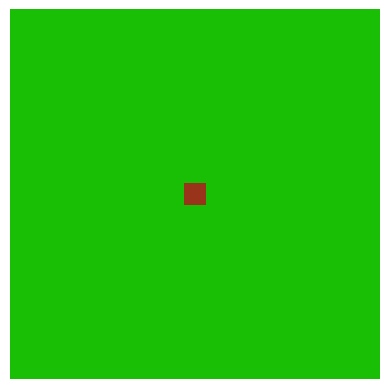

Percentage: 0.6920415224913512


In [ ]:
# Run the Simulation
ptg = burningForest(forest_span=n, t=t, fireProbability=0.1)
HTML(grid_ani.to_html5_video())
print(f"Percentage: {ptg}")

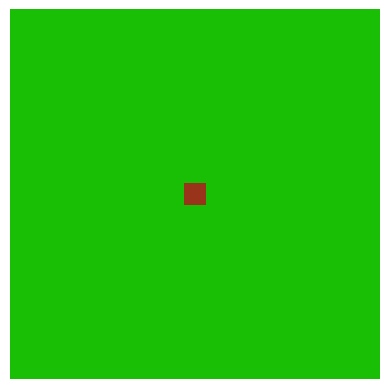

Percentage: 2.0761245674740536


In [ ]:
# Run the Simulation
ptg = burningForest(forest_span=n, t=t, fireProbability=0.3)
HTML(grid_ani.to_html5_video())
print(f"Percentage: {ptg}")

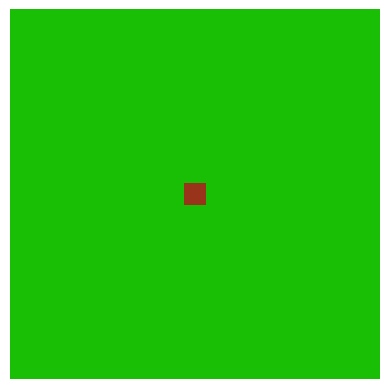

Percentage: 7.266435986159166


In [ ]:
# Run the Simulation
ptg = burningForest(forest_span=n, t=t, fireProbability=0.4)
HTML(grid_ani.to_html5_video())
print(f"Percentage: {ptg}")

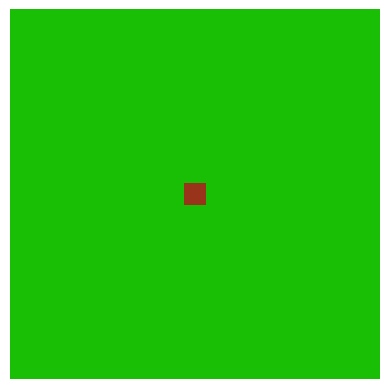

Percentage: 3.460207612456742


In [ ]:
# Run the Simulation
ptg = burningForest(forest_span=n, t=t, fireProbability=0.5)
HTML(grid_ani.to_html5_video())
print(f"Percentage: {ptg}")

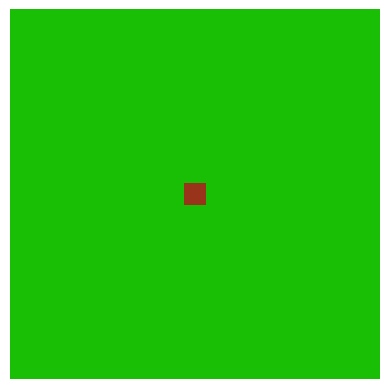

Percentage: 23.875432525951553


In [ ]:
# Run the Simulation
ptg = burningForest(forest_span=n, t=t, fireProbability=0.6)
HTML(grid_ani.to_html5_video())
print(f"Percentage: {ptg}")

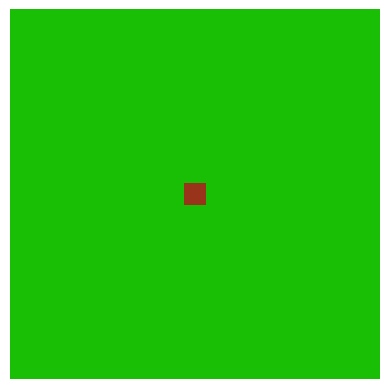

Percentage: 29.411764705882348


In [ ]:
# Run the Simulation
ptg = burningForest(forest_span=n, t=t, fireProbability=0.7)
HTML(grid_ani.to_html5_video())
print(f"Percentage: {ptg}")

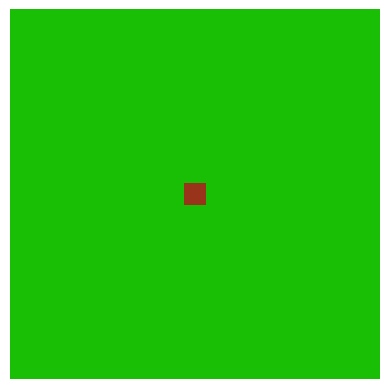

Percentage: 37.0242214532872


In [ ]:
# Run the Simulation
ptg = burningForest(forest_span=n, t=t, fireProbability=0.8)
HTML(grid_ani.to_html5_video())
print(f"Percentage: {ptg}")

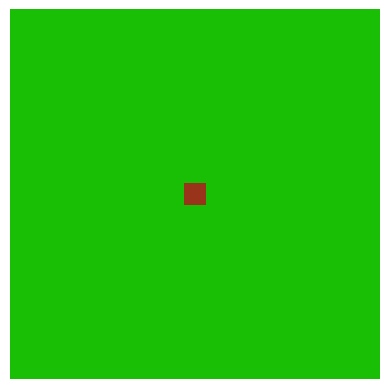

Percentage: 46.36678200692042


In [ ]:
# Run the Simulation
ptg = burningForest(forest_span=n, t=t, fireProbability=0.9)
HTML(grid_ani.to_html5_video())
print(f"Percentage: {ptg}")